# Imports

In [1]:
# Import standard libraries
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# API
import requests
import snowflake.connector

# Date
import datetime as dt
import time
from datetime import timedelta

In [2]:
# # # Gets the cursor
# con = snowflake.connector.connect(
#     user='meagan',
#     password='',
#     account='hu40871.us-east-1',
#     warehouse='ANALYSIS'
#     )

# cur = con.cursor()

# # insert query here
# cur.execute('''
#     SELECT  * 
#     FROM    "WAREHOUSE"."GOLD"."SUBSCRIPTION_RETENTION"
#            ''')

# df=cur.fetch_pandas_all()
# df.head()

In [39]:
silver = pd.read_csv('Acuity.csv')
gold_sub = pd.read_csv('GOLD.csv')

## Acuity

In [47]:
# Create a copy of the DB
silver_acuity = silver.copy()
silver_acuity.shape

(23910, 20)

In [48]:
# Change dates to datetime Dtype
silver_acuity['APPOINTMENT_BODY_DATE'] = pd.to_datetime(silver_acuity['APPOINTMENT_BODY_DATE'])

# Drop unneeded columns
silver_acuity.drop(columns=['EVENT_TS', 'EVENT_TS_UTC', 'ANONYMOUS_ID','APPOINTMENT_BODY_FIRST_NAME',
       'APPOINTMENT_BODY_DATETIME_CREATED', 'APPOINTMENT_BODY_CALENDAR_ID','APPOINTMENT_BODY_CALENDAR_TIMEZONE',\
                    'APPOINTMENT_BODY_TIMEZONE', 'APPOINTMENT_BODY_LAST_NAME', 'APPOINTMENT_BODY_ID',\
                    'APPOINTMENT_BODY_NO_SHOW', \
                    'APPOINTMENT_TYPE_ID'], inplace=True)

# Check for null values
# sns.heatmap(silver_acuity.isnull(), cbar=False)
# silver_acuity.isnull().sum()

In [49]:
silver_acuity.shape

(23910, 8)

In [50]:
silver_acuity['APPOINTMENT_BODY_TYPE'].value_counts()

Hair Consultation                      19845
Hair Mineral Analysis Appointment       2982
Follow Up Consultation                   544
Customer consultation                    201
Case Study                                41
Hair Mineral Analysis - Acquisition       19
Name: APPOINTMENT_BODY_TYPE, dtype: int64

In [51]:
# drop irrelevant appointments
na_dict= {'appointment_canceled' : np.nan,
'appointment_changed' : np.nan,
'appointment_rescheduled' : np.nan}

silver_acuity['EVENT'].replace(na_dict, inplace = True)
silver_acuity.dropna(inplace = True)
silver_acuity['EVENT'].value_counts()

appointment_scheduled    4959
Name: EVENT, dtype: int64

In [52]:
# # drop irrelevant appointments
# na_dict= {'True' : np.nan}

# silver_acuity['APPOINTMENT_BODY_CANCELED'].replace(na_dict, inplace = True)
# silver_acuity.dropna(inplace = True)
# # silver_acuity['APPOINTMENT_BODY_CANCELED'].value_counts()

silver_acuity['APPOINTMENT_BODY_CANCELED'].value_counts()

False    4958
True        1
Name: APPOINTMENT_BODY_CANCELED, dtype: int64

In [53]:
# drop irrelevant appointments
na_dict= {'Hair Mineral Analysis - Acquisition':np.nan,
          'Follow Up Consultation':np.nan,
          'Customer consultation':np.nan,
          'Case Study':np.nan}

silver_acuity['APPOINTMENT_BODY_TYPE'].replace(na_dict, inplace = True)
silver_acuity.dropna(inplace = True)
silver_acuity['APPOINTMENT_BODY_TYPE'].value_counts()

Hair Consultation                    4183
Hair Mineral Analysis Appointment     595
Name: APPOINTMENT_BODY_TYPE, dtype: int64

In [54]:
#Round to the day
silver_acuity['APPOINTMENT_BODY_DATE'] = silver_acuity['APPOINTMENT_BODY_DATE'].dt.round('D')

silver_acuity['Today'] = pd.Timestamp('today')
silver_acuity['Today'] = silver_acuity['Today'].dt.round('D')

silver_acuity['Complete'] = (silver_acuity['Today']>silver_acuity['APPOINTMENT_BODY_DATE'])
silver_acuity['Complete'].value_counts()

True     4154
False     624
Name: Complete, dtype: int64

In [55]:
# Remove appointments in the future
silver_acuity['Complete'] = silver_acuity['Complete'].astype('str')

# drop irrelevant appointments
na_dict= {'False' : np.nan}

silver_acuity['Complete'].replace(na_dict, inplace = True)
silver_acuity.dropna(inplace = True)
silver_acuity['Complete'].value_counts()

True    4154
Name: Complete, dtype: int64

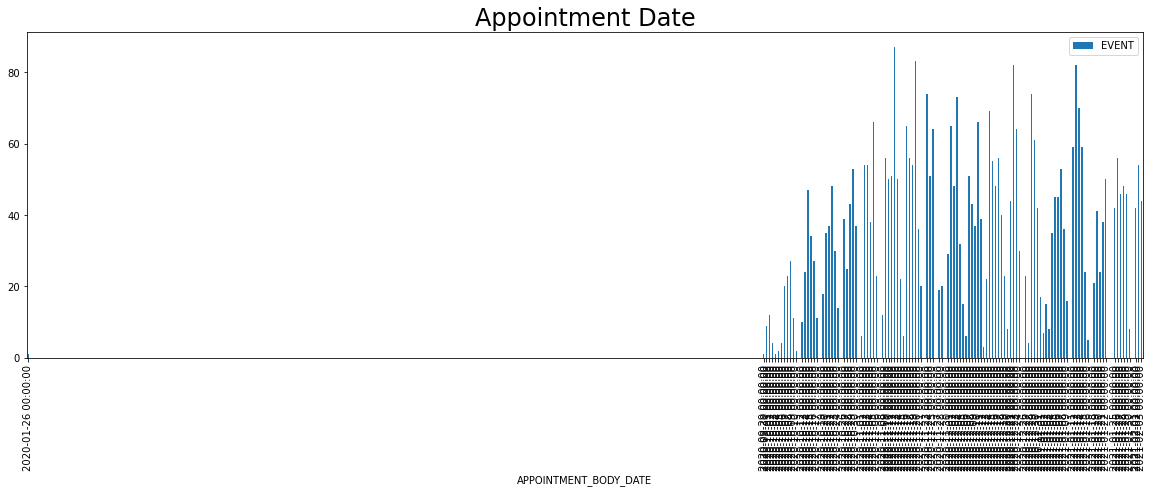

In [56]:
# Group by event, for a visual only 
chart = silver_acuity.groupby(["APPOINTMENT_BODY_DATE"]).agg({'EVENT':'count'})
chart.isna().sum()

chart.plot(kind='bar',figsize=(20,6))
plt.title("Appointment Date", size= 24)
plt.show()

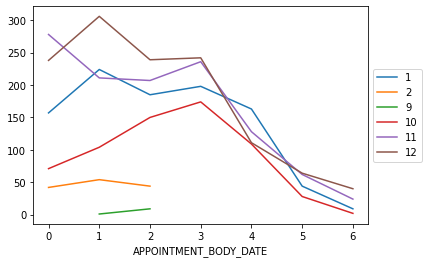

In [57]:
(silver_acuity.groupby([silver_acuity['APPOINTMENT_BODY_DATE'].dt.dayofweek,\
                       silver_acuity['APPOINTMENT_BODY_DATE'].dt.month])\
 ['EVENT'].count()).unstack().plot(kind='line')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

In [58]:
min(silver_acuity['APPOINTMENT_BODY_DATE'])

Timestamp('2020-01-26 00:00:00')

In [59]:
# min(silver_acuity['APPOINTMENT_BODY_DATE'])
# max(silver_acuity['APPOINTMENT_BODY_DATE'])

# Looking at specific email addresses
# silver_acuity.loc[silver_acuity['EMAIL']=='XXXX@yahoo.com']

# AGG
clean_acuity = silver_acuity.loc[silver_acuity.groupby('EMAIL')['APPOINTMENT_BODY_DATE'].idxmin()]
clean_acuity.shape

(3596, 10)

In [60]:
clean_acuity['APPOINTMENT_BODY_TYPE'].value_counts()

Hair Consultation                    3238
Hair Mineral Analysis Appointment     358
Name: APPOINTMENT_BODY_TYPE, dtype: int64

In [61]:
#QA instances
smail = clean_acuity['EMAIL'].nunique()
print ('unique emails = ',smail)

unique emails =  3596


## SUB

In [62]:
# Create a copy of the dataframe
gold = gold_sub.copy()
gold.columns

Index(['EMAIL', 'ITEM_GENDER', 'ITEM_SUB_TYPE', 'ITEM_PRODUCT_CORE_CATEGORY',
       'FIRST_ORDER_AT', 'TOTAL_ORDERS', 'TOTAL_ORDER_VALUE',
       'GROSS_ORDER_VALUE'],
      dtype='object')

In [63]:
# Change dates to datetime 
gold['FIRST_ORDER_AT'] = pd.to_datetime(gold['FIRST_ORDER_AT'])
gold.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 754615 entries, 0 to 754614
Data columns (total 8 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   EMAIL                       754615 non-null  object        
 1   ITEM_GENDER                 754573 non-null  object        
 2   ITEM_SUB_TYPE               754573 non-null  object        
 3   ITEM_PRODUCT_CORE_CATEGORY  754573 non-null  object        
 4   FIRST_ORDER_AT              754615 non-null  datetime64[ns]
 5   TOTAL_ORDERS                754382 non-null  float64       
 6   TOTAL_ORDER_VALUE           754382 non-null  float64       
 7   GROSS_ORDER_VALUE           754587 non-null  float64       
dtypes: datetime64[ns](1), float64(3), object(4)
memory usage: 46.1+ MB


In [64]:
# min(gold['FIRST_ORDER_AT'])
# max(gold['FIRST_ORDER_AT'])

yyy = gold.shape
gemail = gold['EMAIL'].nunique()
print ('shape = ',yyy)
print ('unique emails = ',gemail)

shape =  (754615, 8)
unique emails =  96057


In [65]:
# AGG

df = gold.loc[gold.groupby('EMAIL')['GROSS_ORDER_VALUE'].idxmin()]
df.shape

(96057, 8)

In [66]:
df_total = df['TOTAL_ORDER_VALUE'].mean()
print('Subscription Total Order Value = ',df_total)

df_items  = df['TOTAL_ORDERS'].mean()
print('Subscription Total Orders = ',df_items)

df_orders = df['TOTAL_ORDERS'].mean()
print('Subscription Total Orders = ',df_orders)

Subscription Total Order Value =  325.65437181110286
Subscription Total Orders =  3.9346925175451384
Subscription Total Orders =  3.9346925175451384


## Merge

In [67]:
sub1 = pd.merge(clean_acuity,df,how='left',on='EMAIL')
sub1.shape

(3596, 17)

In [68]:
# Create a copy of the dataframe
sub = sub1.copy()

# sub = sub[[ 'EMAIL','APPOINTMENT_BODY_DATE', 'FIRST_ORDER_AT',\
#            'ITEM_PRODUCT_CORE_CATEGORY', 'ITEM_SUB_TYPE','TOTAL_ITEMS','TOTAL_ORDERS',
#            'ITEM_NAME', 'ITEM_GENDER', 'GROSS_ORDER_VALUE','TOTAL_ORDER_VALUE','SUBSCRIPTION_ID']]

In [69]:
df_total = df['TOTAL_ORDER_VALUE'].mean()
sub_total = sub['TOTAL_ORDER_VALUE'].mean()
print('Subscription Total Order Value = ',df_total)
print('Sub + Consult Total Order Value = ',sub_total)

df_items = df['TOTAL_ORDERS'].mean()
sub_items = sub['TOTAL_ORDERS'].mean()
print('Subscription Total Orders = ',df_items)
print('Sub + Consult Total Orders = ',sub_items)

df_orders = df['TOTAL_ORDERS'].mean()
sub_total = sub['TOTAL_ORDERS'].mean()
print('Subscription Total Orders = ',df_orders)
print('Sub + Consult Total Orders = ',sub_total)

Subscription Total Order Value =  325.65437181110286
Sub + Consult Total Order Value =  354.1359966287379
Subscription Total Orders =  3.9346925175451384
Sub + Consult Total Orders =  4.33164770332912
Subscription Total Orders =  3.9346925175451384
Sub + Consult Total Orders =  4.33164770332912


In [70]:
sub['FIRST_ORDER_AT']=pd.to_datetime(sub['FIRST_ORDER_AT'])

sub['TimeDifference'] = \
(((sub['APPOINTMENT_BODY_DATE']))-(sub['FIRST_ORDER_AT']))

submail = sub['EMAIL'].nunique()
print ('unique emails = ',submail)

unique emails =  3596


In [71]:
# Shouldn't need this
# df['GROSS_ORDER_VALUE']=df['GROSS_ORDER_VALUE'].astype(float, errors='ignore')
# sub['GROSS_ORDER_VALUE'] = sub['GROSS_ORDER_VALUE'].astype(float, errors='ignore')
# df['TOTAL_ORDER_VALUE'] = df['TOTAL_ORDER_VALUE'].astype(float, errors='ignore')
# sub['TOTAL_ORDER_VALUE'] = sub['TOTAL_ORDER_VALUE'].astype(float, errors='ignore')
# df['TOTAL_ITEMS']  = df['TOTAL_ITEMS'].astype(float, errors='ignore')
# df['TOTAL_ORDERS'] = df['TOTAL_ORDERS'].astype(float, errors='ignore')

In [72]:
# clean up item sub
sub.loc[sub['ITEM_SUB_TYPE'] =='GrowthPlan,GrowthPlan 2']= 'Combination'
sub.loc[sub['ITEM_SUB_TYPE'] =='Non-Sub,GrowthPlan 3', 'ITEM_SUB_TYPE']= 'Combination'
sub.loc[sub['ITEM_SUB_TYPE'] =='GrowthPlan,Non-Sub', 'ITEM_SUB_TYPE']= 'Combination'
sub.loc[sub['ITEM_SUB_TYPE'] =='GrowthPlan 3,GrowthPlan', 'ITEM_SUB_TYPE']= 'Combination'
sub.loc[sub['ITEM_SUB_TYPE'] =='GrowthPlan,GrowthPlan', 'ITEM_SUB_TYPE']= 'Combination'
sub.loc[sub['ITEM_SUB_TYPE'] =='GrowthPlan 3,GrowthPlan 3', 'ITEM_SUB_TYPE']= 'Combination'
sub.loc[sub['ITEM_SUB_TYPE'] =='GrowthPlan,GrowthPlan 3', 'ITEM_SUB_TYPE']= 'Combination'
sub.loc[sub['ITEM_SUB_TYPE'] =='GrowthPlan,GrowthPlan,GrowthPlan 3,GrowthPlan 3', 'ITEM_SUB_TYPE']= 'Combination'
sub.loc[sub['ITEM_SUB_TYPE'] =='GrowthPlan 3,GrowthPlan 2,GrowthPlan 3,GrowthPlan 3']= 'Combination'
sub.loc[sub['ITEM_SUB_TYPE'] =='Non-Sub,GrowthPlan 3,Non-Sub', 'ITEM_SUB_TYPE']= 'Combination'
sub.loc[sub['ITEM_SUB_TYPE'] =='GrowthPlan 3,Non-Sub', 'ITEM_SUB_TYPE']= 'Combination'
sub.loc[sub['ITEM_SUB_TYPE'] =='Prepay 6', 'ITEM_SUB_TYPE']= 'Combination'
sub.loc[sub['ITEM_SUB_TYPE'] =='GrowthPlan 3,GrowthPlan', 'ITEM_SUB_TYPE']= 'Combination'
sub.loc[sub['ITEM_SUB_TYPE'] =='GrowthPlan 3,GrowthPlan,GrowthPlan', 'ITEM_SUB_TYPE']= 'Combination'
sub.loc[sub['ITEM_SUB_TYPE'] =='Non-Sub,GrowthPlan 3,GrowthPlan 3,GrowthPlan 2,GrowthPlan 3,GrowthPlan 3,GrowthPlan 3,GrowthPlan 2', 'ITEM_SUB_TYPE']= 'Combination'
sub.loc[sub['ITEM_SUB_TYPE'] =='GrowthPlan 3,GrowthPlan 3,GrowthPlan 2,GrowthPlan 3', 'ITEM_SUB_TYPE']= 'Combination'
sub.loc[sub['ITEM_SUB_TYPE'] =='GrowthPlan 2,GrowthPlan 2', 'ITEM_SUB_TYPE']= 'Combination'
sub.loc[sub['ITEM_SUB_TYPE'] =='GrowthPlan 2,GrowthPlan ', 'ITEM_SUB_TYPE']= 'Combination'
sub.loc[sub['ITEM_SUB_TYPE'] =='GrowthPlan 3,GrowthPlan 2', 'ITEM_SUB_TYPE']= 'Combination'
sub.loc[sub['ITEM_SUB_TYPE'] =='GrowthPlan 2,GrowthPlan 3']= 'Combination'
sub.loc[sub['ITEM_SUB_TYPE'] =='GrowthPlan,GrowthPlan,GrowthPlan', 'ITEM_SUB_TYPE']= 'Combination'
sub.loc[sub['ITEM_SUB_TYPE'] =='GrowthPlan 2,Non-Sub', 'ITEM_SUB_TYPE']= 'Combination'
sub.loc[sub['ITEM_SUB_TYPE'] =='Non-Sub,GrowthPlan']= 'Combination'
sub.loc[sub['ITEM_SUB_TYPE'] =='GrowthPlan 2,GrowthPlan,GrowthPlan 3', 'ITEM_SUB_TYPE']= 'Combination'
sub.loc[sub['ITEM_SUB_TYPE'] =='GrowthPlan 3,GrowthPlan 3,Non-Sub']= 'Combination'
sub.loc[sub['ITEM_SUB_TYPE'] =='Non-Sub,GrowthPlan 2']= 'Combination'
sub.loc[sub['ITEM_SUB_TYPE'] =='GrowthPlan 2,GrowthPlan']= 'Combination'

sub['ITEM_SUB_TYPE'].value_counts()

GrowthPlan      1040
GrowthPlan 3     816
GrowthPlan 2     498
Combination       19
Name: ITEM_SUB_TYPE, dtype: int64

In [73]:
sub.loc[sub['ITEM_PRODUCT_CORE_CATEGORY'] =='Women,Men']= 'Women'
sub.loc[sub['ITEM_PRODUCT_CORE_CATEGORY'] =='Combination']= 'Balance'
sub.loc[sub['ITEM_PRODUCT_CORE_CATEGORY'] =='Women,Balance']= 'Balance'
sub.loc[sub['ITEM_PRODUCT_CORE_CATEGORY'] =='Men,Men']= 'Men'
sub.loc[sub['ITEM_PRODUCT_CORE_CATEGORY'] =='Balance,Men']= 'Balance'
sub.loc[sub['ITEM_PRODUCT_CORE_CATEGORY'] =='Men,Women,Women']= 'Women'

sub['ITEM_PRODUCT_CORE_CATEGORY'].value_counts()

Women              1195
Balance             799
Men                 372
Men,Women             3
Women,Women           2
Men,Balance           1
Balance,Balance       1
Name: ITEM_PRODUCT_CORE_CATEGORY, dtype: int64

In [74]:
# # clean up item gender
# gold.loc[gold['ITEM_GENDER'] =='Men,Women', 'ITEM_GENDER']= 'Combination'
# gold.loc[gold['ITEM_GENDER'] =='Women,Men,Women', 'ITEM_GENDER']= 'Combination'
# gold.loc[gold['ITEM_GENDER'] =='Men,Women,Men,Women,Women,Women,Men,Men', 'ITEM_GENDER']= 'Combination'
# gold.loc[gold['ITEM_GENDER'] =='Men,Women,Women', 'ITEM_GENDER']= 'Combination'
# gold.loc[gold['ITEM_GENDER'] =='Women,Women,Men', 'ITEM_GENDER']= 'Combination'
# gold.loc[gold['ITEM_GENDER'] =='Women,Men,Women,Women', 'ITEM_GENDER']= 'Combination'
# gold.loc[gold['ITEM_GENDER'] =='Women,Men', 'ITEM_GENDER']= 'Combination'
# gold.loc[gold['ITEM_GENDER'] =='Women,All', 'ITEM_GENDER']= 'Women'
# gold.loc[gold['ITEM_GENDER'] =='Women,Women,Women,Women', 'ITEM_GENDER']= 'Women'
# gold.loc[gold['ITEM_GENDER'] =='Women,Women', 'ITEM_GENDER']= 'Women'
# gold.loc[gold['ITEM_GENDER'] =='Men,Men', 'ITEM_GENDER']= 'Men'
# gold.loc[gold['ITEM_GENDER'] =='Women,Women,Men,Women,Men,Men,Men,Women', 'ITEM_GENDER']= 'Combination'
# gold.loc[gold['ITEM_GENDER'] =='Women,Women,Women,Men']= 'Women'

sub['ITEM_GENDER'].value_counts()

Women          1986
Men             372
Balance           8
Men,Women         4
Women,Women       3
Name: ITEM_GENDER, dtype: int64

In [75]:
# Export data
sub.to_csv('sub.csv')